In [1]:
import pandas as pd
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score ,accuracy_score,classification_report,roc_curve,confusion_matrix,precision_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('./Dataset/Train.csv')
train_data.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


In [3]:
train_data.shape

(23856, 18)

In [4]:
train_data.isnull().sum()

INCIDENT_ID           0
DATE                  0
X_1                   0
X_2                   0
X_3                   0
X_4                   0
X_5                   0
X_6                   0
X_7                   0
X_8                   0
X_9                   0
X_10                  0
X_11                  0
X_12                182
X_13                  0
X_14                  0
X_15                  0
MULTIPLE_OFFENSE      0
dtype: int64

In [5]:
train_mode = train_data.X_12.mode()[0]
train_data.fillna(train_mode,inplace=True)
train_data.isnull().sum()

INCIDENT_ID         0
DATE                0
X_1                 0
X_2                 0
X_3                 0
X_4                 0
X_5                 0
X_6                 0
X_7                 0
X_8                 0
X_9                 0
X_10                0
X_11                0
X_12                0
X_13                0
X_14                0
X_15                0
MULTIPLE_OFFENSE    0
dtype: int64

In [6]:
data = train_data.drop(['DATE'],axis=1)
data.head()

,INCIDENT_ID,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


# Encoding

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Function that auto encodes any dataframe column of type category or object.
def dummyEncode(dataset):
        
        columnsToEncode = list(dataset.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                dataset[feature] = le.fit_transform(dataset[feature])
            except:
                print('Error encoding '+feature)
        return dataset
predictors = dummyEncode(data.iloc[:,:-1])
predictors.head()

,INCIDENT_ID,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,362,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36
1,12155,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34
2,11470,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34
3,5307,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34
4,1257,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43


# Stratified Split

In [8]:
from sklearn.model_selection import train_test_split

target = data['MULTIPLE_OFFENSE']

X_train,X_test,Y_train,Y_test = train_test_split(predictors,target, test_size=0.2, random_state=5,stratify=target)

# Balanced Vanilla XGB

Using TensorFlow backend.


On Validation Data
Accuracy is  0.9986028641285365
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       261
           1       1.00      1.00      1.00      5465

    accuracy                           1.00      5726
   macro avg       0.99      1.00      0.99      5726
weighted avg       1.00      1.00      1.00      5726

ROC_AUC_SCORE is  0.9956196345255247
[[ 259    2]
 [   6 5459]]


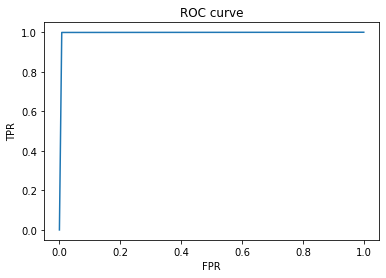

On Test Data
Accuracy is  0.998742665549036
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       214
           1       1.00      1.00      1.00      4558

    accuracy                           1.00      4772
   macro avg       0.99      0.99      0.99      4772
weighted avg       1.00      1.00      1.00      4772

ROC_AUC_SCORE is  0.9948883138612197
[[ 212    2]
 [   4 4554]]


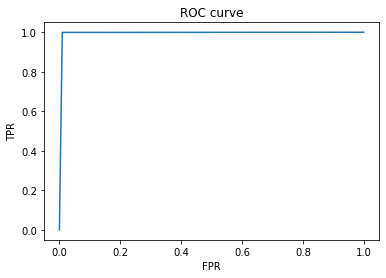

In [9]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.model_selection import cross_val_score
from imblearn.combine import SMOTETomek
import seaborn as sns
import matplotlib.pyplot as plt


def xgboost(dataframe,target):
    X = dataframe
    y = target

    x_train,x_val,y_train,y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    smote = SMOTETomek(random_state=42,sampling_strategy='not majority',n_jobs=-1)
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)

    model = XGBClassifier(n_estimators=150, max_depth=4)
    model.fit(X_sm, y_sm)
    y_pred = model.predict(x_val)
    
    print('On Validation Data')
    print('Accuracy is ',model.score(x_val, y_val))
    print(classification_report(y_val, y_pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    #     print(auc(false_positive_rate, true_positive_rate))
    
    print('ROC_AUC_SCORE is ', roc_auc_score(y_val, y_pred))
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    print(confusion_matrix(y_val,y_pred))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

    print('On Test Data')
    y_pred = model.predict(X_test)
    print('Accuracy is ',model.score(X_test, Y_test))
    print(classification_report(Y_test, y_pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred)
#     print(auc(false_positive_rate, true_positive_rate))

    print('ROC_AUC_SCORE is ', roc_auc_score(Y_test, y_pred))
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    print(confusion_matrix(Y_test,y_pred))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

    return model
    
model = xgboost(X_train,Y_train)

In [10]:
test_data = pd.read_csv('./Dataset/Test.csv')
test_data.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
3,CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
4,CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


In [11]:
test_data_1 = test_data.copy()
test_data_1.drop('DATE',axis=1,inplace=True)
test_data_1.head()

,INCIDENT_ID,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
3,CR_112195,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
4,CR_149832,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


In [12]:
test_mode = test_data_1.X_12.mode()[0]
test_data_1.fillna(test_mode,inplace=True)
test_data_1.isnull().sum()

INCIDENT_ID    0
X_1            0
X_2            0
X_3            0
X_4            0
X_5            0
X_6            0
X_7            0
X_8            0
X_9            0
X_10           0
X_11           0
X_12           0
X_13           0
X_14           0
X_15           0
dtype: int64

In [13]:
test_data_1 = dummyEncode(test_data_1)
preds = model.predict(test_data_1).tolist()

In [14]:
test_data_1['Label'] = preds
test_data_1.head()

,INCIDENT_ID,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,Label
0,8464,0,30,35,7,3,6,4,0,5,1,174,1.0,72,119,23,1
1,325,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34,1
2,8530,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34,1
3,1072,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34,1
4,4402,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43,1


In [15]:
test_data_1['Label'].value_counts()

1    15165
0      738
Name: Label, dtype: int64

In [16]:
test_data.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
3,CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
4,CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


In [17]:
final_df = test_data[['INCIDENT_ID']]
final_df.head()

,INCIDENT_ID
0,CR_195453
1,CR_103520
2,CR_196089
3,CR_112195
4,CR_149832


In [18]:
final_df['MULTIPLE_OFFENSE'] = test_data_1['Label']
final_df.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1


In [19]:
# final_df.to_csv('submission_best.csv',index=False)